# The goal of this Notebook is to train a classifier that can detect cars in a video stream

In [1]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    #Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell),
                                 cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=True,
                                 visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    #Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell),
                                 cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=True,
                                 visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):   
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)



## Define the function we will use to run through the images

In [16]:
from itertools import compress
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True,classifier='Conv_Net'):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  
        if classifier=='Conv_Net':
            prediction=convmodel.predict(np.expand_dims(test_img, axis=0))
            if prediction > 0.5:
                on_windows.append(window)
        else:                
            #4) Extract features for that window using single_img_features()
            features = single_img_features(test_img, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
            #5) Scale extracted features to be fed to classifier
            test_features = scaler.transform(np.array(features).reshape(1, -1))
            #6) Predict using your classifier
            if classifier=='Neural_Net':
                prediction = neural_net.predict(test_features)
            if classifier=='SVM':
                prediction = clf.predict(test_features)
            #7) If positive (prediction == 1) then save the window
            if prediction > 0.5:
                on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
    
def search_windows_gpu(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True,classifier='Conv_Net'):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    test_imgs = np.zeros((len(windows),64,64,3))
    #2) Iterate over all windows in the list
    i=0
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  
        test_imgs[i,:,:,:] = test_img
        i+=1
    predictions=convmodel.predict(test_imgs)
    #on_windows=windows[predictions>0.5]   
    keep_window=np.zeros_like(predictions)
    keep_window[predictions>0.5]=1
    on_windows= list(compress(windows,keep_window))
    #8) Return windows for positive detections
    return on_windows


### Train a classifier using all the training images provided by udacity
The data is split 80/20 betweet train and test

In [3]:
from sklearn.cross_validation import train_test_split
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import pickle
import pdb

#Divide images up into cars and notcars
datafolder = '/media/josealb/HDD_1/Datasets/Self_driving/vehicle_detection/'
images = glob.glob(datafolder+'/*/*/*.*')
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
### Parameters to tweak
colorspace = 'LUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0,1,2 or 'ALL'

t=time.time()
car_features = extract_features(cars,color_space=colorspace, orient=orient,
                                pix_per_cell=pix_per_cell,cell_per_block=cell_per_block
                                ,hog_channel=hog_channel)
notcar_features = extract_features(notcars,color_space=colorspace, orient=orient,
                                pix_per_cell=pix_per_cell,cell_per_block=cell_per_block
                                ,hog_channel=hog_channel)
t2 = time.time()

print(round(t2-t,2), ' Seconds to extract HOG features...')
#Create an aray stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
#Remove NaN values
#X[~np.isnan(X)]=0
# Fit a per-column scaler
X_Scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_Scaler.transform(X)

#Define the labels vector
y=np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

#Split up data into randomized training and test sets
rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print ('Using:',orient,'orientations',pix_per_cell,
      'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:',len(X_train[0]))
# Use a LinearSVC
svc = LinearSVC()
#Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2=time.time()
print(round(t2-t,2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ',round(svc.score(X_test, y_test), 4))

#Check prediction time for a single sample
t=time.time()
n_predict = 10
print ('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print ('For these',n_predict, 'labes: ',y_test[0:n_predict])
t2 = time.time()
print(round(t2-t,5),'Seconds to predict', n_predict, 'labels with SVC')

%mkdir 'models'
with open('models/trained_SVC.p', 'wb') as pickle_file:
    s = pickle.dump(svc,pickle_file)

/home/josealb/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/josealb/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


49.75  Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
10.89 Seconds to train SVC...
Test Accuracy of SVC =  0.98
My SVC predicts:  [ 0.  0.  1.  0.  1.  1.  0.  0.  0.  0.]
For these 10 labes:  [ 0.  0.  1.  0.  1.  1.  0.  0.  0.  0.]
0.00244 Seconds to predict 10 labels with SVC
mkdir: cannot create directory ‘models’: File exists


## Alternatively, let's train a neural network as the classifier

In this first test, the feature extraction will still be "manual" and done in the CPU. The only thing changing is the SVM to a fully connected deep NN

In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Lambda
from keras.layers import Cropping2D
from keras.layers.convolutional import Convolution2D, Conv2D, Conv1D, MaxPooling2D
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.models import load_model


model = Sequential()
#model.add(Conv1D(250,3,input_shape=(X_train.shape[1],)))
#model.add(GlobalMaxPooling1D())
#model.add(Conv1D(500,3,))
#model.add(GlobalMaxPooling1D())
model.add(Dense(400,input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(1000,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(500,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(200,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(50,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(50,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(50,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(50,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(50,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(50,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(50,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1,activation='softmax'))


model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
%mkdir 'models/checkpoints/' 
checkpoint = ModelCheckpoint('models/checkpoints/model-{epoch:03d}-{val_loss:03f}.h5',
                            monitor='val_loss',
                            verbose=0,
                            save_best_only=True,
                            mode = 'auto')

#model.fit(X_train,y_train, batch_size=32, validation_data=(X_test,y_test), \
#             nb_epoch=20, callbacks= [checkpoint], verbose=1)

#model.save('models/neural_net.h5')

Using TensorFlow backend.


mkdir: cannot create directory ‘models/checkpoints/’: File exists


In [5]:
neural_net = load_model('models/neural_net.h5')
#Check prediction time for a single sample
t=time.time()
n_predict = 10
print ('My SVC predicts: ', neural_net.predict(X_test[0:n_predict]))
print ('For these',n_predict, 'labes: ',y_test[0:n_predict])
t2 = time.time()
print(round(t2-t,5),'Seconds to predict', n_predict, 'labels with SVC')


My SVC predicts:  [[-0.23995504]
 [ 0.08368874]
 [ 0.96982241]
 [ 0.08723625]
 [ 0.81779051]
 [ 0.74311501]
 [ 0.14126861]
 [ 0.1103771 ]
 [ 0.40566015]
 [ 0.06049853]]
For these 10 labes:  [ 0.  0.  1.  0.  1.  1.  0.  0.  0.  0.]
0.25959 Seconds to predict 10 labels with SVC


Now, let's create a convolutional neural network that doesn't use any precomputed features

In [6]:
car_images = []
non_car_images = []
for line in cars:
    car_images.append(mpimg.imread(line))
for line in notcars:
    non_car_images.append(mpimg.imread(line))
    
#X = np.vstack((car_images, non_car_images)).astype(np.float64)
#y = np.hstack((np.ones(len(car_images)),np.zeros(len(non_car_images))))

X = np.vstack((non_car_images, car_images)).astype(np.float64)
y = np.hstack((np.zeros(len(non_car_images)),np.ones(len(car_images))))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)


In [8]:
convmodel = Sequential()

convmodel.add(Conv2D(64, 3, 3,
            border_mode='same',
            input_shape=(64, 64, 3)))

convmodel.add(Conv2D(64,3,3,border_mode='same'))
convmodel.add(Activation('relu'))
convmodel.add(MaxPooling2D(pool_size=(2, 2)))

convmodel.add(Conv2D(128,3,3,border_mode='same'))
convmodel.add(Activation('relu'))
convmodel.add(MaxPooling2D(pool_size=(2, 2)))

convmodel.add(Conv2D(256,3,3,border_mode='same'))
convmodel.add(Activation('relu'))
convmodel.add(MaxPooling2D(pool_size=(2, 2)))

convmodel.add(Conv2D(512,3,3,border_mode='same'))
convmodel.add(Activation('relu'))
convmodel.add(MaxPooling2D(pool_size=(2, 2)))

convmodel.add(Flatten())
convmodel.add(Dense(1))
#convmodel.add(BatchNormalization())
#convmodel.add(Dense(100,activation='relu'))
#convmodel.add(BatchNormalization())
#convmodel.add(Dense(500,activation='relu'))
#convmodel.add(BatchNormalization())
#convmodel.add(Dense(200,activation='relu'))
#convmodel.add(BatchNormalization())
#convmodel.add(Dense(50,activation='relu'))
#convmodel.add(BatchNormalization())
#convmodel.add(Dense(50,activation='relu'))
##convmodel.add(BatchNormalization())
#convmodel.add(Dense(50,activation='relu'))
#convmodel.add(BatchNormalization())
#convmodel.add(Dense(50,activation='relu'))
#convmodel.add(BatchNormalization())
#convmodel.add(Dense(50,activation='relu'))
#convmodel.add(BatchNormalization())
#convmodel.add(Dense(50,activation='relu'))
#convmodel.add(BatchNormalization())
#convmodel.add(Dense(50,activation='relu'))
#convmodel.add(BatchNormalization())
#convmodel.add(Dense(1,activation='softmax'))

convmodel.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
%mkdir 'models/checkpoints/' 
checkpoint = ModelCheckpoint('models/checkpoints/model-{epoch:03d}-{val_loss:03f}.h5',
                            monitor='val_loss',
                            verbose=0,
                            save_best_only=True,
                            mode = 'auto')

#convmodel.fit(X,y, batch_size=32, validation_data=(X_test,y_test), \
#             nb_epoch=20, callbacks= [checkpoint], verbose=1,shuffle=True)

#convmodel.save('models/conv_net.h5')

mkdir: cannot create directory ‘models/checkpoints/’: File exists


In [19]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

class Heatmap:
    """A class to create a heatmap from detections"""
    height = 1280
    width = 720
    member_heatmap = np.zeros([720,1280]).astype(np.float)
    decay = 0.5

    def f(self):
        return 'hello world'
    
    def add_heat(self, bbox_list):
        # Iterate through list of bboxes
        self.member_heatmap -= self.decay
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            self.member_heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        self.member_heatmap[self.member_heatmap>heat_clipping]=heat_clipping
        return self.member_heatmap# Iterate through list of bboxes

    def reset_heat_map(self):
        self.member_heatmap = np.zeros([720,1280]).astype(np.float)

In [29]:
color_space=colorspace
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
heat_threshold = 2 
heat_clipping = 20

In [30]:
#initialize class heatmap
my_heatmap = Heatmap() 

def process_image(image,visualization=False,use_time_smoothing=True):    
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    y_start_stop = [400, None] # Min and max in y to search in slide_window()

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.8, 0.8))
    
    #pdb.set_trace()
    windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(135, 135), xy_overlap=(0.8, 0.8))
    
    windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(68, 68), xy_overlap=(0.8, 0.8))
    
    windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(180, 180), xy_overlap=(0.8, 0.8))
    
    windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(250, 250), xy_overlap=(0.8, 0.8))

    hot_windows = search_windows_gpu(image, windows, svc, X_Scaler, color_space=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat,classifier='Conv_Net')                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
  
    

    # Read in a pickle file with bboxes saved
    # Each item in the "all_bboxes" list will contain a 
    # list of boxes for one of the images shown above
    box_list = hot_windows

    # Read in image similar to one shown above 
    #image = mpimg.imread('test_image.jpg')
    heat = np.zeros_like(image[:,:,0]).astype(np.float)



    # Add heat to each box in box list
    heat = my_heatmap.add_heat(box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #draw_img = draw_labeled_bboxes(np.copy(image), labels)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    if visualization:
        fig = plt.figure()#(figsize=(24,16))
        plt.imshow(window_img)
        fig = plt.figure()
        plt.imshow(draw_img)
        plt.title('Car Positions')
        fig = plt.figure()
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
    if use_time_smoothing==False:
        my_heatmap.reset_heat_map()
    return draw_img


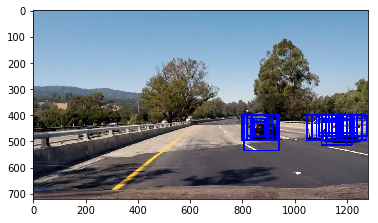

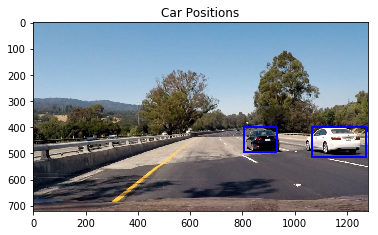

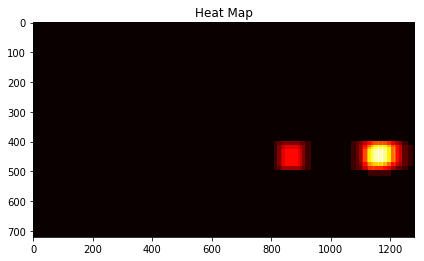

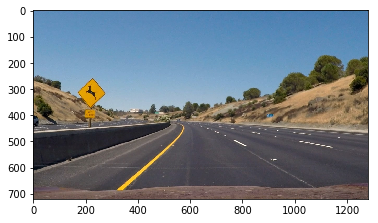

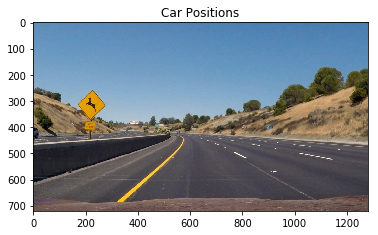

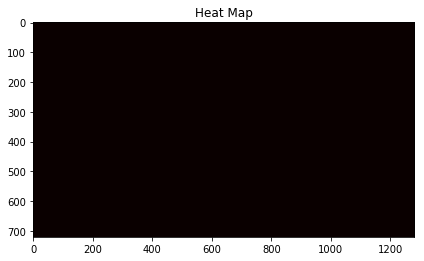

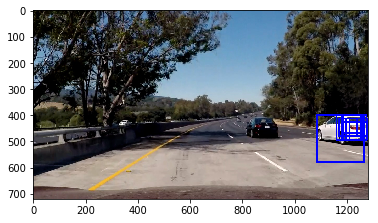

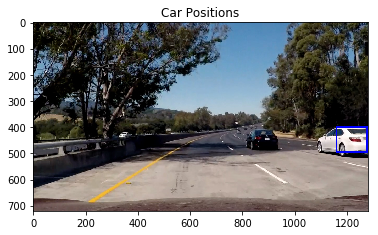

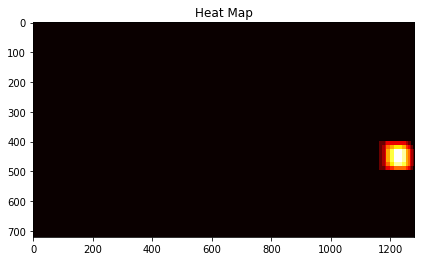

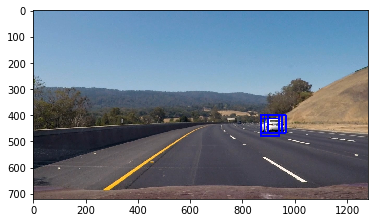

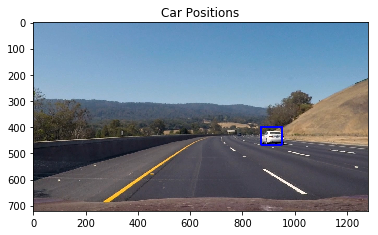

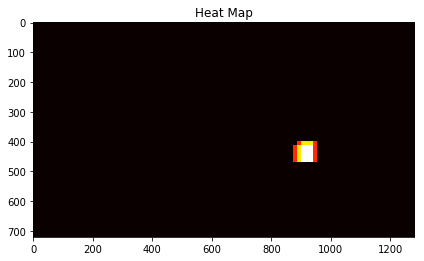

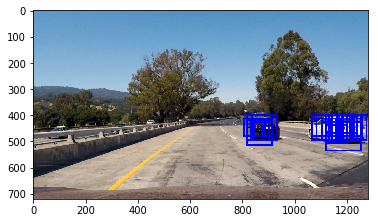

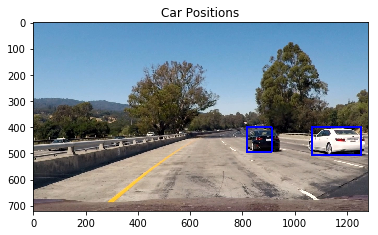

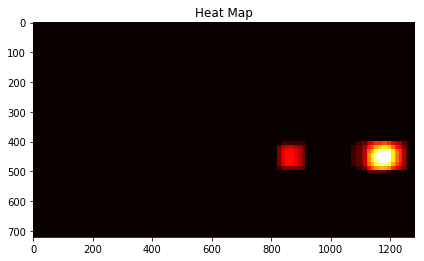

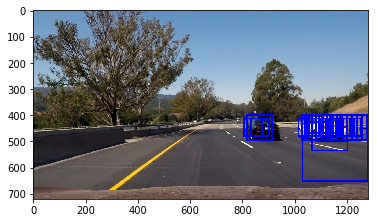

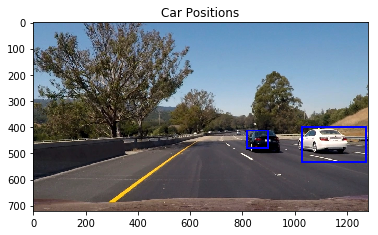

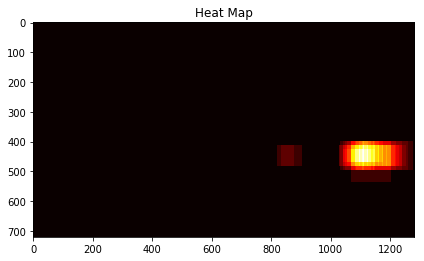

In [27]:
svc = pickle.load( open( 'models/trained_SVC.p', "rb" ) )
neural_net = load_model('models/neural_net.h5')
convmodel = load_model('models/conv_net.h5')



%matplotlib inline
from scipy.ndimage.measurements import label

images = glob.glob('test_images/*.jpg')

for file in images:
    image = mpimg.imread(file)
    process_image(image,visualization=True,use_time_smoothing=False)

### Finally, we evaluate the performance with the video file

In [21]:
import imageio
imageio.plugins.ffmpeg.download()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [31]:
%mkdir test_videos_output
white_output = 'test_videos_output/test_video_s_channel_nn.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(0,12)
#clip1 = VideoFileClip("project_video.mp4").subclip(0,3)
clip1 = VideoFileClip("project_video.mp4").subclip(24,36)

#clip1 = VideoFileClip("test_videos/my_video_barcelona_b20.mp4")

my_heatmap.reset_heat_map()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

mkdir: cannot create directory ‘test_videos_output’: File exists
[MoviePy] >>>> Building video test_videos_output/test_video_s_channel_nn.mp4
[MoviePy] Writing video test_videos_output/test_video_s_channel_nn.mp4


100%|█████████▉| 300/301 [04:07<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video_s_channel_nn.mp4 

CPU times: user 2min 34s, sys: 26.3 s, total: 3min
Wall time: 4min 7s


Helper function to find out some details about the variables

In [ ]:
def show_information(variable,name):
    print('********')
    print('Showing information on: ',name)
    print('Data type: ',type(variable))
    print('Data shape: ', variable.shape)
    print('Data: ',variable)
    print('Mean: ',np.mean(variable))
    print('Min: ',np.min(variable))
    print('Max: ',np.max(variable))
    
#show_information(X[0],'Training features before pre-processing')
#show_information(X_train[0],'Training features after scaling')
#show_information(image,'Test images before pre-processing')
#show_information(processed_image,'Test images after first scaling')
#show_information(X,'Training features')
show_information(y_train,'y_train')